<h1>Problem statement:</h1><br>
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



<h3>Importing Essential Libraries</h3>


In [1]:
import os
import pathlib
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from tensorflow.keras import utils
utils.to_categorical  # used for converting labels to one-hot-encoding  
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from keras.applications.resnet50 import ResNet50
from keras import backend as K 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2024-02-04 16:07:00.816362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:07:00.816502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:07:00.826212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 16:07:01.218456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 16:07:10.130763: W tensorflow/compiler/tf2

<h3>Loading pictures and making Dictionary of images and labels</h3>


In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('Train')
data_dir_test = pathlib.Path('Test')
     

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


<h3>Load using keras preprocessing</h3><br>
Let's load these images off disk using the helpful image_dataset_from_directory utility.



<h3>Create a dataset</h3><br>
Define some parameters for the loader:



In [3]:
batch_size = 32
img_height = 180
img_width = 180


In [4]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
   


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
     

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [7]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [8]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

2024-02-04 16:08:32.975385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 162 of 256
2024-02-04 16:08:37.552409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


32
32


<h3><b>Visualize the data</b></h3><br>
Todo, create a code to visualize one instance of all the nine classes present in the dataset


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    


2024-02-04 16:09:13.923601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 230 of 256
2024-02-04 16:09:16.306613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-04 16:09:24.012949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2024-02-04 16:09:32.762310: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30108672 exceeds 10% of free system memory.
2024-02-04 16:09:35.435382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 18 of 1000
2024-02-04 16:09:36.693705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30108672 exceeds 10% of free system memory.
2024-02-04 16:09:37.966519: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] All

32
32


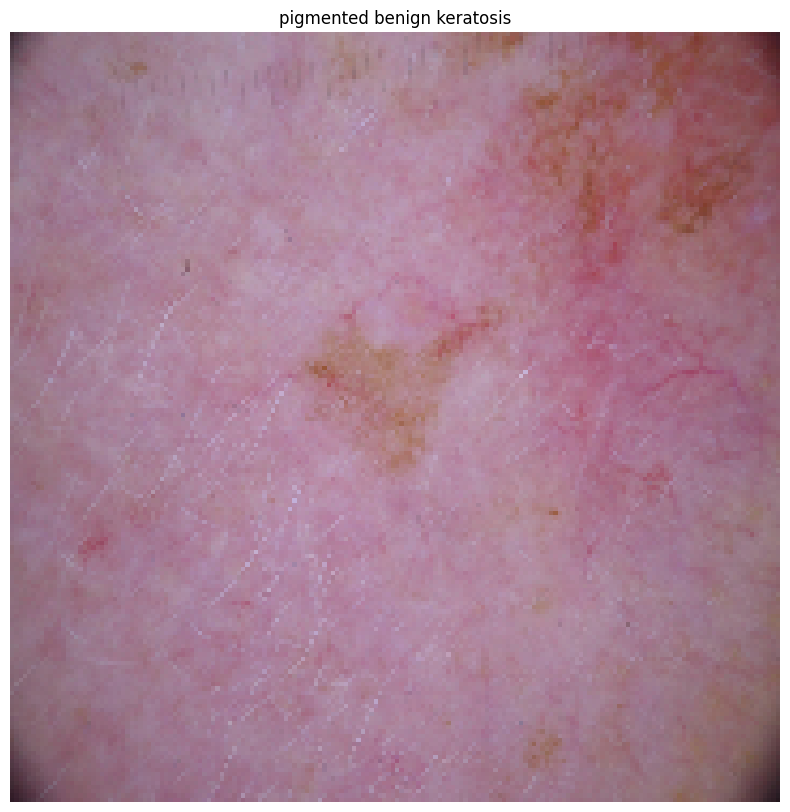

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")



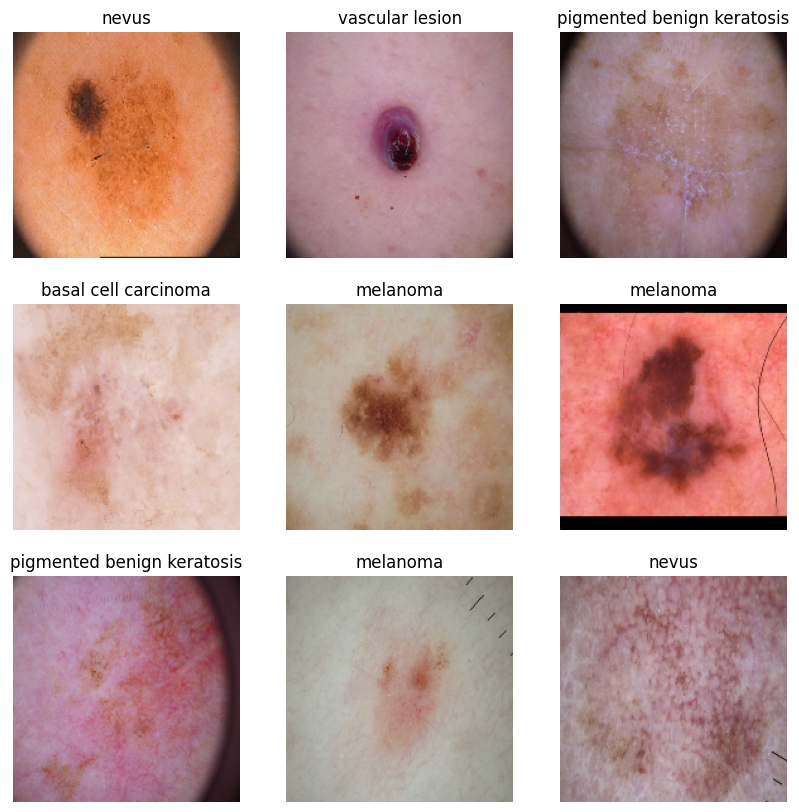

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


<h3>Create the model</h3>

In [12]:

num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:

#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs =20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0011 - accuracy: 0.2377

2024-02-04 16:24:45.140959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 190 of 256
2024-02-04 16:24:46.421931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


56/56 [==============================] - 578s 10s/step - loss: 2.0011 - accuracy: 0.2377 - val_loss: 1.8810 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 434s 8s/step - loss: 1.8279 - accuracy: 0.3265 - val_loss: 1.8393 - val_accuracy: 0.3020
Epoch 3/20
56/56 [==============================] - 516s 9s/step - loss: 1.6095 - accuracy: 0.4397 - val_loss: 1.4649 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 461s 8s/step - loss: 1.4390 - accuracy: 0.4972 - val_loss: 1.4591 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 542s 10s/step - loss: 1.3067 - accuracy: 0.5536 - val_loss: 1.3620 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 591s 11s/step - loss: 1.2315 - accuracy: 0.5692 - val_loss: 1.3367 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 595s 11s/step - loss: 1.1118 - accuracy: 0.6060 - val_loss: 1.2860 - val_accuracy: 0.5570
Epoch 8/20
56/56 [==

### Train the model


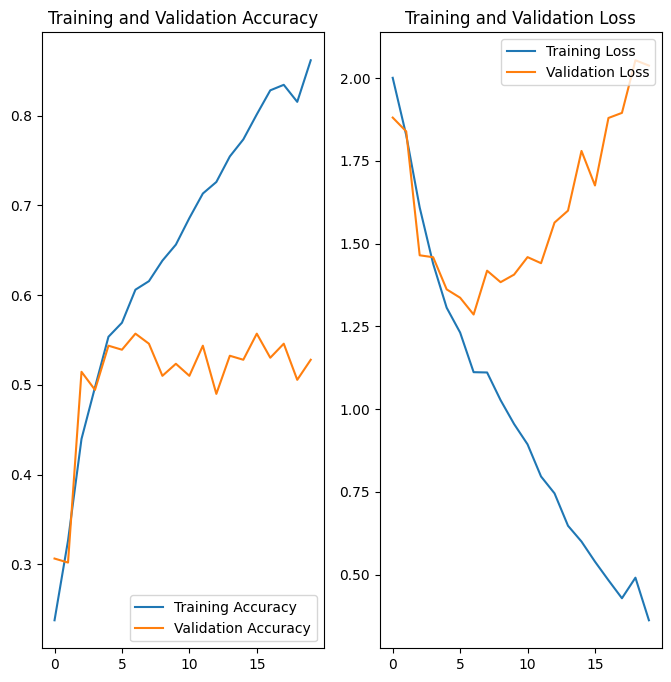

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Visualizing training results

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

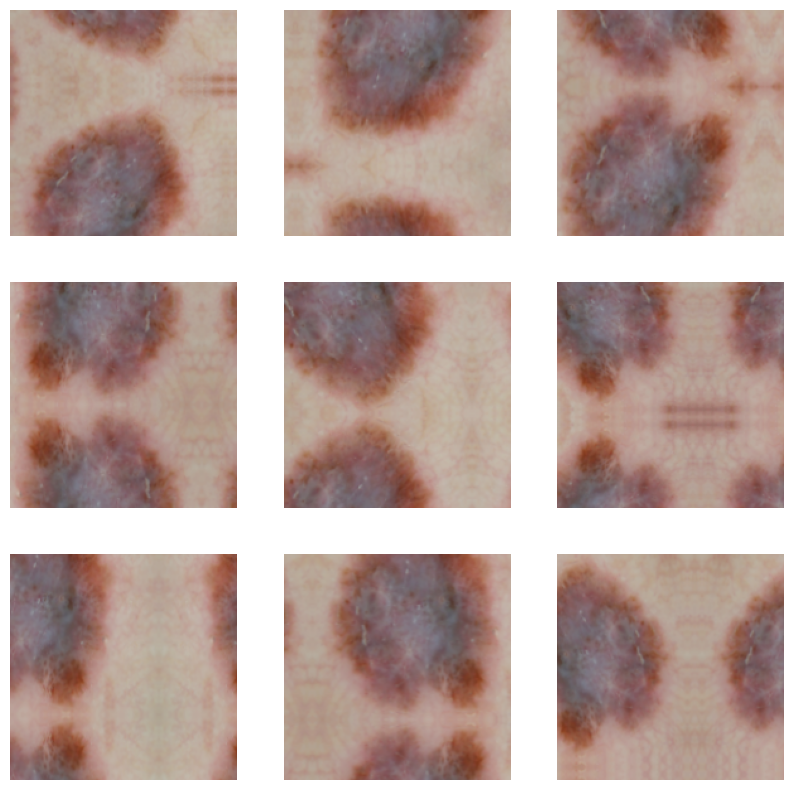

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")